In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import torch
from torch.autograd import Variable
from torch.utils import data
from torch import nn
from torch import optim
from torch.utils import data

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import sys
sys.path.append('..')#
from util import add_angles, angle_between, angled_vector, sub_angles

In [2]:
df_train = pd.read_csv( '../../data/processed/rf_train.csv')
df_test = pd.read_csv( '../../data/processed/rf_test.csv')

# Put dt column last for both dfs.
# Otherwise reshaping will have weird results.
cols = list(df_train.columns)
cols.remove('dt')
df_train = df_train[cols + ['dt']]
df_test = df_test[cols + ['dt']]

In [3]:
y_labels = ['y_0', 'y_1']
y_train_np = df_train.loc[df_train['dt'] == 0, y_labels].values
y_test_np = df_test.loc[df_train['dt'] == 0, y_labels].values

n_dts = len(np.unique(df_train['dt']))
n_features = df_train.shape[1] - 3# # minus rows dt, y_0, y_1

X_train_np = df_train.drop(labels=y_labels + ['dt'], axis=1).values
X_test_np = df_test.drop(labels=y_labels + ['dt'], axis=1).values

# Reshape from (dts*kicks, features) to (features, dts, kicks)
X_train_np = X_train_np.reshape(X_train_np.shape[0]//n_dts, n_dts,n_features)
X_test_np = X_test_np.reshape(X_test_np.shape[0]//n_dts, n_dts, n_features)

# Transpose to (dts, kicks, features)
X_train_np = X_train_np.transpose(1,0, 2)
X_test_np = X_test_np.transpose(1,0, 2)

# To Tensors
X_train = torch.from_numpy(X_train_np).float()
y_train = torch.from_numpy(y_train_np).float()

X_test = torch.from_numpy(X_test_np).float()
y_test = torch.from_numpy(y_test_np).float()

# Sanity check if shape is correct.
from sklearn.linear_model import RidgeCV
linear = RidgeCV()
linear.fit(X_train_np[-1,:,:], y_train_np)
print(linear.score(X_train_np[0,:,:], y_train_np), linear.score(X_test_np[0,:,:], y_test_np))

class LSTMDataset(data.Dataset):
    def __init__(self, X, y):
        super(data.Dataset, self).__init__
        
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[1]
    
    def __getitem__(self, idx):
        return self.X[:, idx,:], self.y[idx,:]

train_data = LSTMDataset(X_train, y_train)

def collate(batch):
    result = []
    Xs = []
    ys = []
    for elem in batch:
        X = elem[0]
        y = elem[1]
        Xs.append(X)
        ys.append(y)
    return torch.stack(Xs, dim=1), torch.stack(ys, dim=0)

train_loader = data.DataLoader(train_data,
                               batch_size=64, 
                               collate_fn=collate,
                               pin_memory=True,
                               num_workers=6)

0.12448713830576463 0.09587104013911792


In [4]:
def gaussian_distribution(y, mu, sigma):
    norm_factor = 1.0/ (2*np.pi)**0.5

    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.contiguous().view(-1,1).expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * norm_factor

def determinant(mat):
    """Compute determinant for 2x2 matrices"""
    assert(mat.shape == (2,2))
    return mat[0,0] * mat[1,1] - mat[0,1] * mat[1,0]

def multivariate_gaussian(x, mu, sigma):
    """
    X: (N, d)
    mu: (N, K, d)
    sigma: (N, K, d)
    return: pdf (K, N, d)
    """
    covar_inv = 1 / sigma # N, K, d
    norm_factor = (2 * np.pi * sigma).prod(dim=2) ** -0.5 # N, K
    K = mu.size(1)
    x = x.unsqueeze(1).repeat(1,K,1) # N, K, d
    dist = x - mu
    # this line is very dubios, double check
    exponent = -0.5 * (dist * covar_inv * dist).sum(dim=-1) # N, K

    pdf = exponent.exp() * norm_factor
    return pdf # N, K


class MixtureLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pi, sigma, mu, y):
        # Compute log likelihood
        ll = (multivariate_gaussian(y, mu, sigma)) * pi      

        ll = ll.sum(dim=1)
        ll =  -ll.log()      
        return ll.mean()

In [5]:
class MLPFrontend(nn.Module):
    def __init__(self, n_features, n_hidden):
        super().__init__()
               
        self.in_to_hidden = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.Tanh(),
            nn.Dropout(p=0.1, inplace=False),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh()
        )
   
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=5.0/3)

    def forward(self, x): 
        x = x[0,:,:]
        hidden = self.in_to_hidden(x)
         
        return hidden
 
class RNNFrontend(nn.Module):
    def __init__(self, n_features, n_hidden):
        super().__init__()
               
        self.n_hidden = n_hidden
        
        self.in_to_hidden = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.Tanh(),
            nn.Dropout(p=0.1, inplace=False),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh()
        )
        
        # TODO: Set initial hidden state (how?)
        self.in_to_hidden = nn.GRU(input_size=n_features,
                                   hidden_size=n_hidden,
                                   num_layers=1)
   
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=5.0/3)

    def forward(self, x):
        output, hn = self.in_to_hidden(x)
        hn = hn.view(-1, self.n_hidden)
        return hn

# https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb
class MixtureRF(nn.Module):
    def __init__(self, frontend, n_hidden, n_components):
        super().__init__()
        
        self.n_components = n_components
        
        self.frontend = frontend
        
        n_output = 2
        n_params = n_components * n_output
        
        # Each vector is modelled as mixture of gaussians with diag. covariance 
        self.z_pi = nn.Linear(n_hidden, n_components)
        self.z_sigma = nn.Linear(n_hidden, n_params)
        self.z_mu = nn.Linear(n_hidden, n_params)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=5.0/3)

    def forward(self, x):
        batch_size = x.shape[1]
        
        hidden = self.frontend(x)
         
        pi = self.z_pi(hidden).view(batch_size, self.n_components)
        pi = nn.functional.softmax(self.z_pi(hidden), 1)
        
        # sigma: variances of components, need to be > 0
        # 10e-6 added for numerical stability
        # TODO: Compare exp vs softmax!
        # sigma = torch.exp(z_sigma(z_h)) + 10e-6
        sigma = nn.functional.softplus(self.z_sigma(hidden)) + 10e-6
        sigma = sigma.view(batch_size, self.n_components, -1)
        
        # mu: mean, can be arbitrary
        mu = self.z_mu(hidden).view(batch_size, self.n_components, -1)         

        return [pi, sigma, mu]

In [6]:
n_hidden = 60
rnn = RNNFrontend(n_features=n_features, n_hidden=n_hidden)

mlp = MLPFrontend(n_features=n_features, n_hidden = n_hidden)
model = MixtureRF(frontend=rnn, n_hidden=n_hidden, n_components=2).to(device)

optimizer = optim.Adam(model.parameters(), weight_decay=0)
#criterion = nn.MSELoss().to(device)
criterion = MixtureLoss().cuda().to(device)

In [7]:
for it in range(100):
    loss_sum = 0.0
    for batch in train_loader:
        x, y = [b.to(device) for b in batch]

        optimizer.zero_grad()
        
        out = model(x)
        if True or isinstance(model, MixtureRF):
            pi, sigma, mu = out
            loss = criterion(pi, sigma, mu, y)
        else:
            loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss

    if (it % 10) == 0:
        print(loss_sum.item())
        
if False and not isinstance(model, MixtureRF):
    with torch.no_grad():
        y_hat = model(X_test.to(device)).unsqueeze(0).data.cpu().numpy().reshape(-1,2)
        #print(spearmanr(y_test_np[:,0], y_hat[:,0]), spearmanr(y_test_np[:,1], y_hat[:,1]))
        y_hat = (np.apply_along_axis(lambda x: angle_between(np.array([1,0]), x), arr=y_hat, axis=1))
        y = (np.apply_along_axis(lambda x: angle_between(np.array([1,0]), x), arr=y_test_np, axis=1))
        diff = np.abs(sub_angles(y_hat, y))
def angle_mean(x):
    a = np.sum(np.sin(x))
    b = np.sum(np.cos(x))
    return np.arctan2(a, b)
    np.rad2deg(angle_mean(diff)), np.rad2deg(angle_mean(y))

629.4154663085938
552.1069946289062
536.4133911132812
524.63916015625
513.9100341796875
502.66107177734375
490.8296813964844
478.5425109863281
465.53082275390625
452.3558044433594


In [8]:
pis, _, mus = [o.cpu().detach().numpy() for o in model(X_test.to(device))]
y_test_hat = (np.stack((pis, pis), axis=-1) *  mus).sum(axis=1)

pis, _, mus = [o.cpu().detach().numpy() for o in model(X_train.to(device))]
y_train_hat = (np.stack((pis, pis), axis=-1) *  mus).sum(axis=1)

from sklearn.metrics import r2_score
r2_score(y_train_np, y_train_hat), r2_score(y_test_np, y_test_hat)

(0.2364141450193169, -0.03485728874216065)

Pi:	  [0.7968777  0.20312233] 
Sigma:	  [[0.14958127 0.20833498]
 [1.2879412  1.0144893 ]] 
Mu:	 [[1.5549463  0.11109991]
 [2.0148966  0.3661785 ]]
(3000, 2)


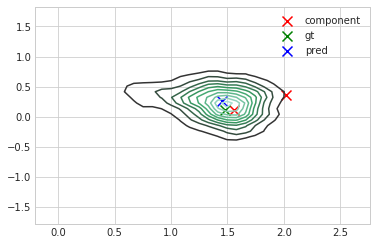

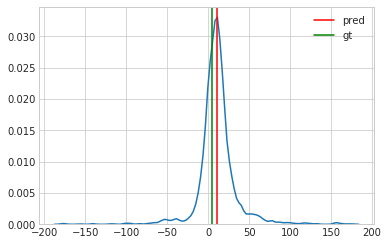

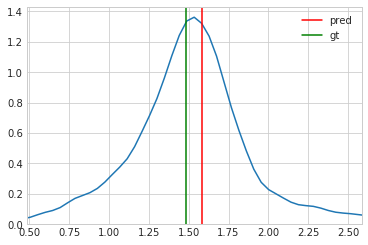

In [9]:
sns.set_style('whitegrid')

n_samples = 1000
idx = np.random.randint(low=0,
                        high=len(y_test_np))
#import random
#idx = random.choice(np.where(X_test_np[:,10] == 1)[0])
with torch.no_grad():
    out = model(X_test[:,idx,:].unsqueeze(0).to(device))

to_numpy = lambda o: np.repeat(o.data.cpu().numpy(), n_samples, axis=0)
pi, sigma, mu = [to_numpy(o) for o in out]
print('Pi:\t ', pi[0,:],
      '\nSigma:\t ', sigma[0,:,:],
     '\nMu:\t', mu[0,:,:])

def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

def mixture_sample(pi, sigma, mu):
    component = gumbel_sample(pi)
    def idx_col(arr, cols):
        return arr[np.arange(len(arr)), cols]
    sigma = idx_col(sigma, component)
    mu = idx_col(mu, component)
    #print(mu[component,:])
    return np.random.normal(loc=mu, scale=sigma)

samples = mixture_sample(pi, sigma, mu)
print(samples.shape)
vectors = samples
angles = np.rad2deg(np.apply_along_axis(lambda x: angle_between(np.array([1,0]), x), arr=vectors, axis=1))

vector_hat = vectors.mean(axis=0)
vector_gt = y_test_np[idx]
angle_gt = np.rad2deg(angle_between(np.array([1,0]), vector_gt))

kick_length_hat = np.linalg.norm(vectors, axis=1)
kick_length_gt = np.linalg.norm(y_test_np[idx,:])

def get_bounds(a,b, window):
    l = min(a,b) - window
    u = max(a,b) + window
    return l,u
        
fig, ax = plt.subplots()
sns.kdeplot(samples[:,0], samples[:,1], ax=ax)
mu_x, mu_y = np.hsplit(mu[0], [1])
ax.scatter(mu_x, mu_y, c='red', marker='x', s=100, linewidths=4, label='component')
ax.scatter(vector_gt[0], vector_gt[1], c='green', marker='x', s=100, linewidths=4, label='gt')
ax.scatter(vector_hat[0], vector_hat[1], c='blue', marker='x', s=100, linewidths=4, label='pred')

ax.legend()

b_x = np.percentile(a=samples[:,0], q=[1,98])
b_y = np.percentile(a=samples[:,1], q=[1,98])
ax.set_xlim(b_x)
ax.set_ylim(b_y)

fig, ax = plt.subplots()
sns.kdeplot(angles, ax=ax)
pred, gt = angles.mean(), angle_gt
ax.axvline(x=pred, label='pred', c='red')
ax.axvline(x=gt, label='gt', c='green')
#ax.set_xlim(get_bounds(pred, gt, 20))
ax.legend()

fig, ax = plt.subplots()
sns.kdeplot(kick_length_hat, ax=ax)
pred, gt = kick_length_hat.mean(), kick_length_gt
ax.axvline(x=pred, label='pred', c='red')
ax.axvline(x=gt, label='gt', c='green')
ax.set_xlim(get_bounds(pred, gt, 1))
ax.legend()

0.7968777 [0.14958127 0.20833498] [1.5549463  0.11109991]
0.20312233 [1.2879412 1.0144893] [2.0148966 0.3661785]


(-4, 4)

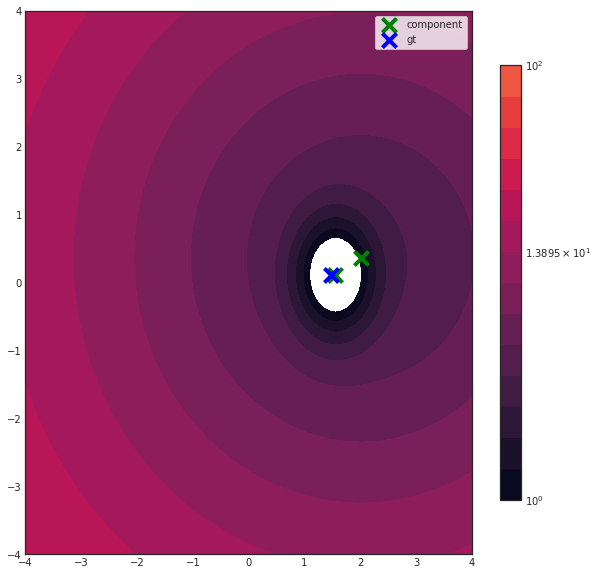

In [10]:
sns.set_style('white')
from scipy import stats
from matplotlib import colors

x = np.linspace(-5,5, num=100)
y = np.linspace(-5, 5, num=100)
X, Y = np.meshgrid(x,y)
XX = np.array([X.ravel(), Y.ravel()]).T

Z = np.zeros_like(X)*1.0
for p, s, m in zip(pi[0], sigma[0], mu[0]):
    print(p,s,m)
    gaussian = stats.multivariate_normal(mean=m, cov=np.diag(s))
    ll = gaussian.pdf(XX)
    ll = ll.reshape(X.shape)
    Z +=  p * ll
Z = -np.log(Z)
# todo: fix
Z[Z < 0] = 1e-6

fig, ax = plt.subplots(figsize=(10,10))
cs = ax.contourf(X,Y,Z, levels=np.logspace(0,2, num=15), norm=colors.LogNorm(vmin=1.0, vmax=1000))
fig.colorbar(cs, shrink=0.8, extend='both')
mu_x, mu_y = np.hsplit(mu[0], [1])
ax.scatter(mu_x, mu_y, c='green', marker='x', s=200, zorder=10, linewidth=4, label='component')
ax.scatter(vector_gt[0], vector_gt[1], c='blue', marker='x', s=200, zorder=10, linewidth=4, label='gt')
ax.legend(frameon=True)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)
